<a href="https://colab.research.google.com/github/mvapontes/KEGGAPI.jl/blob/main/examples/Case3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Hardware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2023-08-04 13:48:04 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [1]:
using Pkg

In [2]:
Pkg.add("Revise")
Pkg.add("DataFrames")
Pkg.add("BenchmarkTools")
Pkg.add(url="https://github.com/bwbioinfo/KEGGAPI.jl")
Pkg.add("TestImages")
Pkg.add("Images")
Pkg.add("FileIO")
Pkg.add("Colors")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed OrderedCollections ─ v1.6.2
   Installed LoweredCodeUtils ─── v2.3.0
   Installed Requires ─────────── v1.3.0
   Installed JuliaInterpreter ─── v0.9.23
   Installed CodeTracking ─────── v1.3.2
   Installed Revise ───────────── v3.5.3
    Updating `~/.julia/environments/v1.8/Project.toml`
  [295af30f] + Revise v3.5.3
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [da1fd8a2] + CodeTracking v1.3.2
  [aa1ae85d] + JuliaInterpreter v0.9.23
  [6f1432cf] + LoweredCodeUtils v2.3.0
  [bac558e1] + OrderedCollections v1.6.2
  [ae029012] + Requires v1.3.0
  [295af30f] + Revise v3.5.3
  [8ba89e20] + Distributed
Precompiling project...
  ✓ Requires
  ✓ OrderedCollections
  ✓ CodeTracking
  ✓ JuliaInterpreter
  ✓ LoweredCodeUtils
  ✓ Revise
  6 dependencies successfully precompiled in 22 seconds. 20 already precompiled.
   Resolving package versions...
   Installed TableTraits ─────────

In [10]:
using Revise
using DataFrames
using BenchmarkTools
using KEGGAPI
using Images
using TestImages
using Colors

# Case 3: Identify compound in Kegg Database



### 1. Get compound information in Kegg Database

To determine if a compound is included in KEGG database and obtain its information, the function find takes as input the string "compound" and the name of the compound

In [4]:
@time kegg_compound = KEGGAPI.find("compound", "chitin")
DataFrame(
  kegg_compound.data,
  kegg_compound.colnames
)

 16.108868 seconds (16.57 M allocations: 850.406 MiB, 2.87% gc time, 93.99% compilation time: 5% of which was recompilation)


Row,ID,Compound Name
,String,String
1,cpd:C00461,"Chitin; beta-1,4-Poly-N-acetyl-D-glucosamine; [1,4-(N-Acetyl-beta-D-glucosaminyl)]n; [1,4-(N-Acetyl-beta-D-glucosaminyl)]n+1"


#### 1.1 Get compund information

In [30]:
kegg_compund_info = KEGGAPI.kegg_get(["cpd:C00461"])


2-element Vector{Vector{String}}:
 ["https://rest.kegg.jp/get/cpd:C00461/"]
 ["ENTRY       C00461                      Compound\nNAME        Chitin;\n            beta-1,4-Poly-N-acetyl-D-glucosamine;\n            [1,4-(N-Acetyl-beta-D-glucosaminyl)]n;\n            [1,4-(N-Acetyl-beta-D-glucosaminyl)]n+1\nFORMULA     (C8H13NO5)n\nREMARK      Same as: G10483\nREACTION    R01206 R02333 R02334 R02335 R11660\nPATHWAY     map00520  Amino sugar and nucleotide sugar metabolism\n            map01100  Metabolic pathways\nENZYME      1.14.99.53      2.4.1.16        3.2.1.14        3.5.1.41\nDBLINKS     CAS: 1398-61-4\n            PubChem: 3745\n            ChEBI: 17029\n            NIKKAJI: J209.135F\nATOM        16\n            1   C1y C    17.7100  -15.8200\n            2   C1y C    17.7100  -17.2200\n            3   C1y C    18.9224  -17.9200\n            4   C1y C    20.1349  -17.2200\n            5   C1x C    20.1349  -15.8200\n            6   O2x O    18.9224  -15.1200\n            7   C1b 

### 2. Get image of the compund of interest

The get_image function is to download a any image, the imput is the compound number as "cpd:CXXXXX"

The save_image function is to save the figure in a png file. The input is a string with the name of the file and the extension ".png"

In [ ]:
@time kegg_image = KEGGAPI.get_image("cpd:C00461")
@time KEGGAPI.save_image(kegg_image, "chitin.png")

  0.189900 seconds (205 allocations: 17.109 KiB)
  0.000203 seconds (13 allocations: 744 bytes)


"chitin.png"

### 3. Visualize download compound

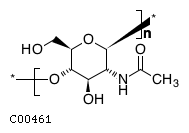

In [ ]:
img = load("chitin.png")

### 4. Identify thre reactions linked to the compound of interest

The ouput is one line for every time the compound is found

In [7]:
@time kegg_reaction = KEGGAPI.link("reaction", "cpd:C00461")
DataFrame(
  kegg_reaction.data,
  kegg_reaction.colnames
)

  1.484113 seconds (829 allocations: 109.625 KiB, 1.04% compilation time)


Row,Target ID,Source ID
,String,String
1,cpd:C00461,rn:R01206
2,cpd:C00461,rn:R01206
3,cpd:C00461,rn:R02333
4,cpd:C00461,rn:R02334
5,cpd:C00461,rn:R02334
6,cpd:C00461,rn:R02335
7,cpd:C00461,rn:R02335
8,cpd:C00461,rn:R11660
9,cpd:C00461,rn:R11660


#### 5. Get information about the reactions which chitin is involved

In [9]:
@time kegg_reaction_info = KEGGAPI.kegg_get(kegg_reaction.data[2])
kegg_reaction_info[2]

  0.259760 seconds (269 allocations: 35.617 KiB)


9-element Vector{String}:
 "ENTRY       R01206             " ⋯ 527 bytes ⋯ " endochitinase B [EC:3.2.1.14]"
 "ENTRY       R01206             " ⋯ 527 bytes ⋯ " endochitinase B [EC:3.2.1.14]"
 "ENTRY       R02333             " ⋯ 467 bytes ⋯ ".1.41]\nDBLINKS     RHEA: 10467"
 "ENTRY       R02334             " ⋯ 480 bytes ⋯ " endochitinase B [EC:3.2.1.14]"
 "ENTRY       R02334             " ⋯ 480 bytes ⋯ " endochitinase B [EC:3.2.1.14]"
 "ENTRY       R02335             " ⋯ 455 bytes ⋯ ".1.16]\nDBLINKS     RHEA: 16640"
 "ENTRY       R02335             " ⋯ 455 bytes ⋯ ".1.16]\nDBLINKS     RHEA: 16640"
 "ENTRY       R11660             " ⋯ 394 bytes ⋯ " C00001\nENZYME      1.14.99.53"
 "ENTRY       R11660             " ⋯ 394 bytes ⋯ " C00001\nENZYME      1.14.99.53"

### 6. Get image of the reaction of interest

The get_image function is to download a any image, the imput is the reactio number as "rn:RXXXXX"

The save_image function is to save the figure in a png file. The input is a string with the name of the file and the extension ".png"

In [ ]:
@time kegg_image = KEGGAPI.get_image("rn:R01206")
@time KEGGAPI.save_image(kegg_image, "r01206.png")

  0.205849 seconds (200 allocations: 25.391 KiB)
  0.000274 seconds (13 allocations: 744 bytes)


"r01206.png"

### 7. Visualize download reaction

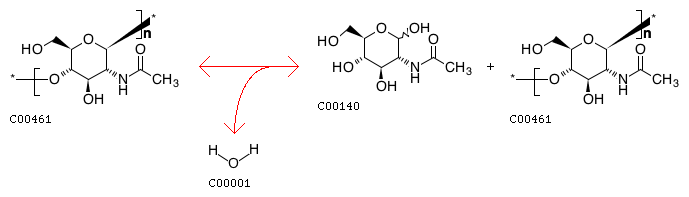

In [ ]:
img = load("r01206.png")